Asmaa Abdul-Amin<br>
CRN#: 40397<br>
Date: 1 August 2025<br>
# The-Cost-of-Democracy<br>
### How has the last election cycle affected the cost of average grocery store items?

Fetch historical prices for Ground Beef, Sugar, and Eye Drops using SerpAPI and fallback web results:
- Computes changes from 2024 to the current year.
- Saves results to CSV and plots for visualization.


In [42]:
!pip install serpapi
!pip install google-search-results
!pip install python-dotenv

In [4]:
#!/usr/bin/env python3
"""
Asmaa Abdul-Amin
CRN#: 40397
25 July 2025

SerpApi-based price estimation with Google Shopping → Web fallback,
per-item bounds, and median aggregation.

Fetches prices for Sugar, Ground Beef, and Eye Drops from 2016, 2024, and current year.
Calculates price changes, saves results to CSV, and generates plots.
"""

import os
import re
import time
from datetime import datetime
from statistics import median
from typing import List, Dict, Optional

import pandas as pd
import matplotlib.pyplot as plt
from serpapi import GoogleSearch
from dotenv import load_dotenv

# -------------------- ENV & PATHS --------------------
load_dotenv()
API_KEY = os.getenv("SERPAPI_KEY") or os.getenv("API_KEY")
if not API_KEY:
    raise ValueError("Missing SERPAPI_KEY (or API_KEY) in environment / .env")
try:
    BASE_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # __file__ is not defined (e.g., running in interactive mode or notebook)
    BASE_DIR = os.getcwd()

PLOTS_DIR = os.path.join(BASE_DIR, "plots/")
DATA_DIR = os.path.join(BASE_DIR, "data/")
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

THROTTLE = 1.0  # seconds between SerpApi calls

# -------------------- ITEMS & SITES --------------------
high_yield_sites = ["walmart.com", "target.com", "amazon.com", "instacart.com"]
ITEMS_SITES: List[tuple] = [
    ("Sugar", "price of Sugar, white, per lb", high_yield_sites),
    ("Ground_Beef", "price of ground beef per pound", high_yield_sites),
    ("Eye_Drops", "price of Pataday eye drops", high_yield_sites),
]
ITEM_RULES: Dict[str, Dict] = {
    "Sugar":   {"min": 3.00, "max": 50.00, "terms": ["Lb", "Lbs", "Pound", "Pounds", "lbs", "lb"]},
    "Ground_Beef":  {"min": 5.00, "max": 50.00, "terms": ["Lb", "Pound"]},
    "Eye_Drops":    {"min": 3.00, "max": 50.00, "terms": []},
}

# -------------------- HELPERS --------------------
def extract_prices_from_text(txt: str) -> List[float]:
    if not txt:
        return []
    matches = re.findall(r"\$?\s*(\d{1,3}(?:,\d{3})*(?:\.\d{2})?)", txt)
    return [float(m.replace(",", "")) for m in matches if m]

def fetch_prices_shopping(query: str) -> List[float]:
    params = {"engine": "google_shopping", "q": query, "api_key": API_KEY, "num": 10}
    try:
        res = GoogleSearch(params).get_dict()
        out = []
        for r in res.get("shopping_results", []):
            price_field = r.get("price")
            if isinstance(price_field, str):
                out.extend(extract_prices_from_text(price_field))
            elif isinstance(price_field, (int, float)):
                out.append(float(price_field))
        return out
    except Exception as e:
        print(f"[shopping error] {query}: {e}")
        return []

def fetch_prices_web(query: str) -> List[float]:
    params = {"engine": "google", "q": query, "api_key": API_KEY}
    try:
        res = GoogleSearch(params).get_dict()
        snippet = res.get("organic_results", [{}])[0].get("snippet", "") or ""
        return extract_prices_from_text(snippet)
    except Exception as e:
        print(f"[web error] {query}: {e}")
        return []

def get_year_price(item_key: str, base_query: str, year: str, sites: List[str]) -> Optional[float]:
    rules = ITEM_RULES.get(item_key, {"min": 0.5, "max": 100.0, "terms": []})
    terms_suffix = " ".join(rules.get("terms", []))
    collected = []

    for site in sites:
        q = f"{base_query} {terms_suffix} price in {year} USA site:{site}".strip()
        collected.extend(fetch_prices_shopping(q))
        time.sleep(THROTTLE)

    if not collected:
        collected.extend(fetch_prices_shopping(f"{base_query} {terms_suffix} price in {year} USA"))

    if not collected:
        for site in sites:
            collected.extend(fetch_prices_web(f"{base_query} {terms_suffix} price in {year} USA site:{site}"))
            time.sleep(THROTTLE)

    if not collected:
        collected.extend(fetch_prices_web(f"{base_query} {terms_suffix} price in {year} USA"))

    lo, hi = rules["min"], rules["max"]
    bounded = [p for p in collected if lo <= p <= hi]
    return round(median(bounded), 2) if bounded else None

# -------------------- PRINT UTILITY --------------------
def print_formatted_changes(df, base_year=2024):
    year_cols = [c for c in df.columns if c.endswith("Price ($)")]
    years = sorted(int(c.split()[0]) for c in year_cols)
    if base_year not in years:
        base_year = years[0]
    current_year = max(years)

    base_col = f"{base_year} Price ($)"
    current_col = f"{current_year} Price ($)"

    df[f"Change ({base_year} → {current_year}) ($)"] = df[current_col] - df[base_col]
    df[f"Change ({base_year} → {current_year}) (%)"] = (
        (df[current_col] - df[base_col]) / df[base_col] * 100
    )

    print(f"\n📢 Formatted ({base_year} → {current_year}):")
    for _, r in df.iterrows():
        if pd.notna(r[base_col]) and pd.notna(r[current_col]):
            print(f"{r['Item']}: ${r[base_col]:.2f} → ${r[current_col]:.2f} "
                  f"| Change: ${r[f'Change ({base_year} → {current_year}) ($)']:.2f} "
                  f"({r[f'Change ({base_year} → {current_year}) (%)']:.1f}%)")

# -------------------- BUILD TABLE --------------------
def build_serp_tables_2024_to_current(items_sites: List[tuple]) -> pd.DataFrame:
    current_year = str(datetime.now().year)
    rows = []
    for item_key, query_base, sites in items_sites:
        print(f"\nFetching prices for: {item_key}")
        p2016 = get_year_price(item_key, query_base, "2016", sites)
        time.sleep(THROTTLE)
        p2024 = get_year_price(item_key, query_base, "2024", sites)
        time.sleep(THROTTLE)
        pNOW = get_year_price(item_key, query_base, current_year, sites)
        time.sleep(THROTTLE)

        rows.append({
            "Item": item_key,
            "2016 Price ($)": p2016,
            "2024 Price ($)": p2024,
            f"{current_year} Price ($)": pNOW,
        })
    df = pd.DataFrame(rows)
    df.to_csv(os.path.join(DATA_DIR, "price_changes_serpapi_2024_to_current.csv"), index=False)
    print_formatted_changes(df)
    return df

# -------------------- PLOTS --------------------
def make_plots(df: pd.DataFrame, current_year: str):
    col_pct = f"Change (2024 → {current_year}) (%)"
    if col_pct in df.columns:
        df_plot = df[["Item", col_pct]].dropna()
        if not df_plot.empty:
            plt.figure(figsize=(10, 6))
            plt.bar(df_plot["Item"], df_plot[col_pct])
            plt.title(f"Percent Change (2024 → {current_year}) by Item")
            plt.xticks(rotation=45)
            plt.ylabel("Percent Change (%)")
            plt.tight_layout()
            plt.savefig(os.path.join(PLOTS_DIR, f"serpapi_percent_change_2024_{current_year}.png"), dpi=200)
            plt.close()

def build_price_paths_since_2016(items_sites: List[tuple]) -> pd.DataFrame:
    current_year = str(datetime.now().year)
    rows = []
    for item_key, query_base, sites in items_sites:
        print(f"\nBuilding price path since 2016 for: {item_key}")
        p2016 = get_year_price(item_key, query_base, "2016", sites)
        time.sleep(THROTTLE)
        p2020 = get_year_price(item_key, query_base, "2020", sites)
        time.sleep(THROTTLE)
        p2024 = get_year_price(item_key, query_base, "2024", sites)
        time.sleep(THROTTLE)
        pNOW = get_year_price(item_key, query_base, current_year, sites)
        time.sleep(THROTTLE)
        rows.append({"Item": item_key, "2016": p2016, "2020": p2020, "2024": p2024, current_year: pNOW})
    df_paths = pd.DataFrame(rows)
    df_paths.to_csv(os.path.join(DATA_DIR, "price_paths_since_2016.csv"), index=False)
    return df_paths

def plot_price_paths_since_2016(df_paths: pd.DataFrame):
    year_cols = [c for c in df_paths.columns if c.isdigit()]
    if len(year_cols) < 2:
        return
    plt.figure(figsize=(12, 6))
    for _, row in df_paths.iterrows():
        yvals = [row.get(c) for c in year_cols]
        plt.plot(year_cols, yvals, marker="o", label=row["Item"])
    plt.title("Price Paths by Item (2016 → Latest)")
    plt.xlabel("Year")
    plt.ylabel("Estimated Price ($)")
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, "serpapi_price_paths_since_2016.png"), dpi=200)
    plt.close()

# -------------------- MAIN --------------------
def main():
    current_year = str(datetime.now().year)
    df_24_cur = build_serp_tables_2024_to_current(ITEMS_SITES)
    make_plots(df_24_cur, current_year)
    df_paths = build_price_paths_since_2016(ITEMS_SITES)
    plot_price_paths_since_2016(df_paths)

if __name__ == "__main__":
    main()


Fetching prices for: Sugar

Fetching prices for: Ground_Beef

Fetching prices for: Eye_Drops

📢 Formatted (2024 → 2025):
Sugar: $9.29 → $13.70 | Change: $4.41 (47.5%)
Ground_Beef: $9.00 → $9.99 | Change: $0.99 (11.0%)
Eye_Drops: $14.05 → $16.73 | Change: $2.68 (19.1%)

Building price path since 2016 for: Sugar

Building price path since 2016 for: Ground_Beef

Building price path since 2016 for: Eye_Drops


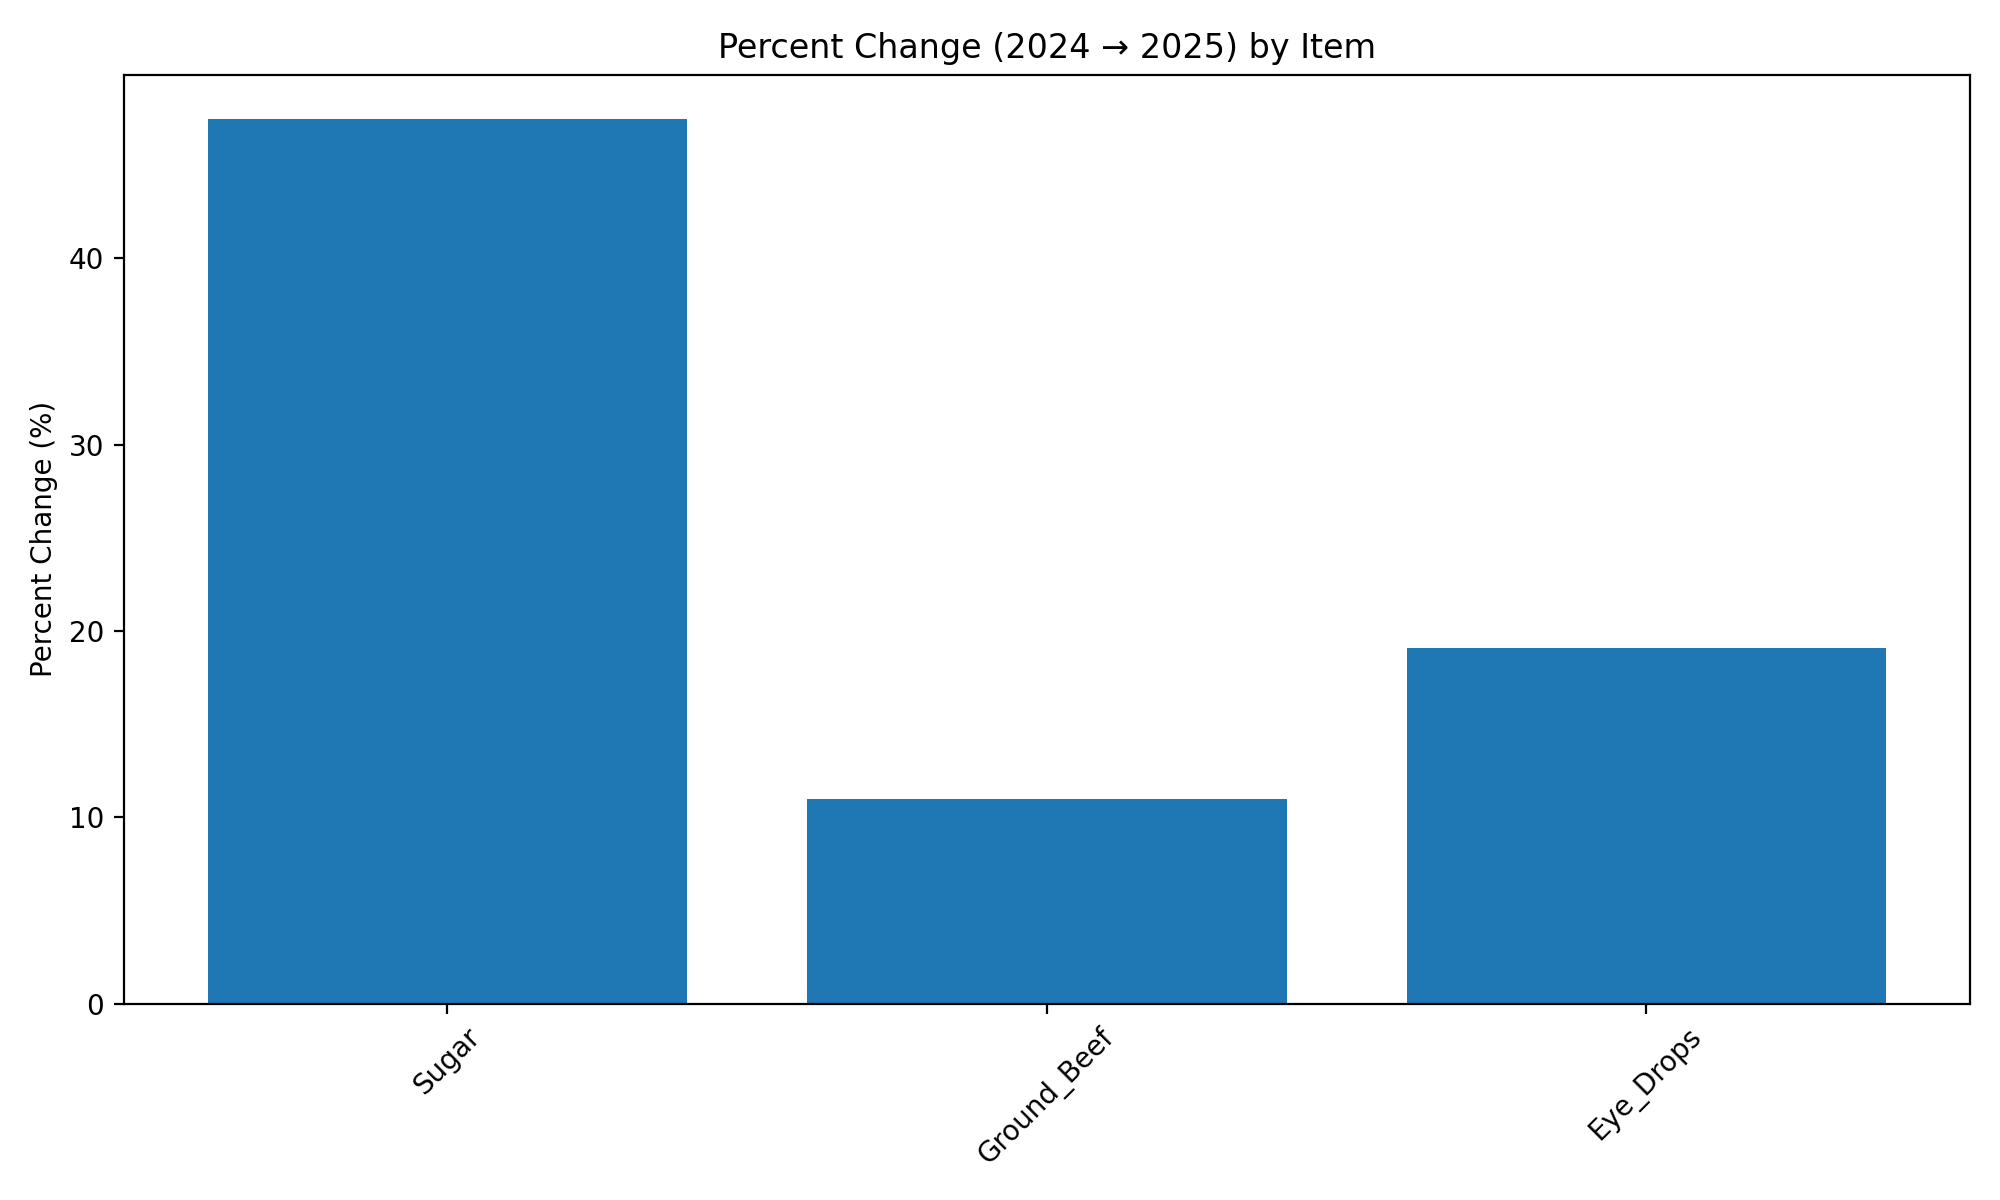

In [5]:
from IPython.display import Image, display

# Display the image in Python
image_path = "plots/serpapi_percent_change_2024_2025.png"
display(Image(filename=image_path))

We can see that the cost of these items has risen since 2024.

# How do those changes in price compare to the previous election cycle?

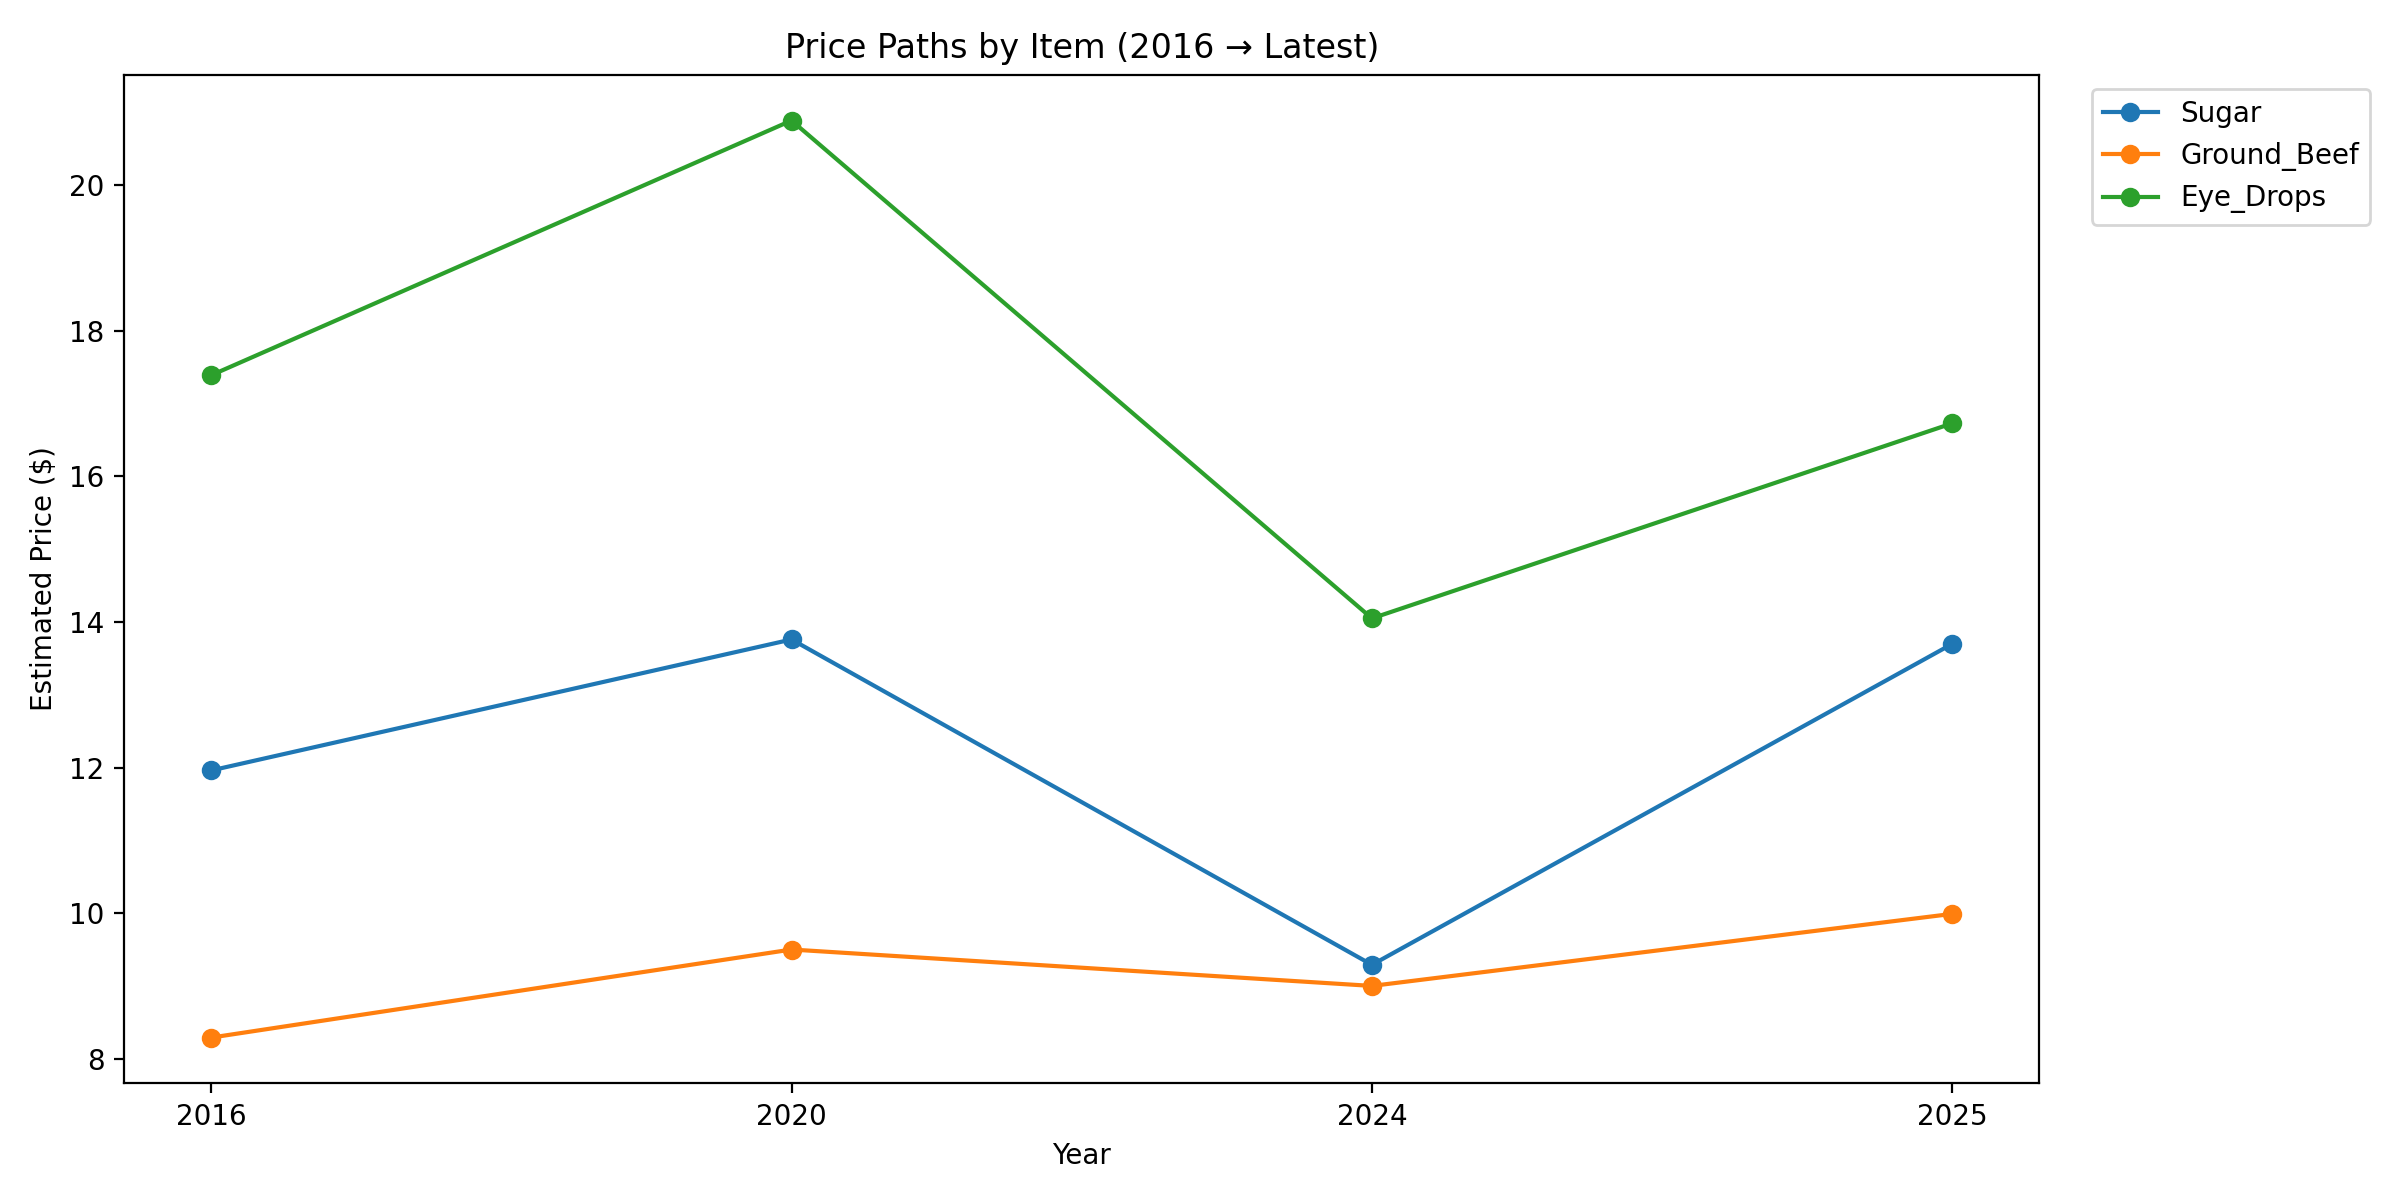

In [6]:
# Display the image in Python
image_path = "plots/serpapi_price_paths_since_2016.png"
display(Image(filename=image_path))

- We can see that prices rose during Trump's first term (2016-2020)
- Price then started to decline during the Biden administration (2020-2024)
- The data is also showing we are now back in an upward trend since the last election (2024-2025).